In this notebook we will build a speech recognition model.  

Below we'll import the libraries we'll be using.

In [1]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Next, we'll download the dataset of speech commands from tensorflow.

In [2]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

--2021-01-08 16:13:02--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  98.4MB/s    in 16s     

2021-01-08 16:13:18 (90.3 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



Here, we unzip the file we downloaded from tensorflow.

In [3]:
!mkdir speech_commands
!tar -C ./speech_commands -xf speech_commands_v0.01.tar.gz 

Let's plot the waveform of an example spoken command, `samples`.

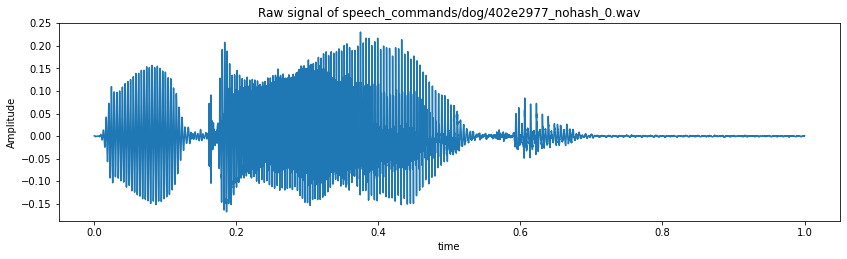

In [4]:
train_path = 'speech_commands/'
filename = train_path+'dog/402e2977_nohash_0.wav'
samples, sample_rate = librosa.load(filename, sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw signal of ' + filename)
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

Below we will play the the `samples` audio command.

In [5]:
ipd.Audio(samples,rate=sample_rate,autoplay=True)

Below we load the data into `all_wavs` and their respective labels into `all_labs`.  The labels are either `yes` or `no`.

We'll also print the number of examples in `all_wavs`.

In [6]:
import os

directory = 'speech_commands/'

all_wavs = []
all_labs = []
for label in ['cat', 'dog']:
    print(label)
    wavs = [f for f in os.listdir(directory + label) if f.endswith('.wav')]
    for wav in wavs:
        samples, sample_rate = librosa.load(directory + label + '/' + wav, sr = 16000)
        if(len(samples)== 16000): 
            all_wavs.append(samples)
            all_labs.append(label)

print(len(all_wavs))

cat
dog
3062


Below we split our training and test data.  `X_train` is our processed audio files for training and `y_train` are their labels.  `X_test` and `y_test` are our test audio files and their labels, respectively.

In [7]:
from sklearn.model_selection import train_test_split
 
all_wavs = np.array(all_wavs).reshape(-1,16000,1)
all_labs = np.array([lab == 'dog' for lab in all_labs])
X_train, X_test, y_train, y_test = train_test_split(all_wavs,all_labs,test_size = 0.2)

In the following lines, we will build together the layers of our model for speech recognition.

In [8]:

from keras.layers import Conv1D, Input, MaxPooling1D, Flatten, Dense
from keras.models import Model
 
inputs = Input(shape=(16000,1))
 
#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
 
#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
 
#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
 
#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
 
#Flatten layer
conv = Flatten()(conv)
 
#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
 
#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
 
outputs = Dense(1, activation='sigmoid')(conv)
 
model = Model(inputs, outputs)

We then `fit` the model.  We use a `mean_squared_error` `loss` and optimize the weigths using use `adam` as our `optimizer`. We iterate of the data 15 times.  Each time, or `epoch`, we print out the `accuracy` and `loss` of our model so far.

In [9]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
 
model.fit(X_train, y_train ,epochs=15, batch_size=64)

Epoch 1/15
39/39 [==============================] - 8s 22ms/step - loss: 0.2219 - accuracy: 0.6096
Epoch 2/15
39/39 [==============================] - 1s 20ms/step - loss: 0.1348 - accuracy: 0.8142
Epoch 3/15
39/39 [==============================] - 1s 20ms/step - loss: 0.0654 - accuracy: 0.9186
Epoch 4/15
39/39 [==============================] - 1s 19ms/step - loss: 0.0416 - accuracy: 0.9473
Epoch 5/15
39/39 [==============================] - 1s 19ms/step - loss: 0.0345 - accuracy: 0.9569
Epoch 6/15
39/39 [==============================] - 1s 19ms/step - loss: 0.0508 - accuracy: 0.9352
Epoch 7/15
39/39 [==============================] - 1s 20ms/step - loss: 0.0333 - accuracy: 0.9571
Epoch 8/15
39/39 [==============================] - 1s 20ms/step - loss: 0.0275 - accuracy: 0.9681
Epoch 9/15
39/39 [==============================] - 1s 19ms/step - loss: 0.0318 - accuracy: 0.9595
Epoch 10/15
39/39 [==============================] - 1s 19ms/step - loss: 0.0238 - accuracy: 0.9706
Epoch 11/

We then report the final `accuracy` and `loss` on the `X_test` and `y_test` data.

In [11]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 7ms/step - loss: 0.0374 - accuracy: 0.9527


[0.03743195906281471, 0.9526916742324829]

In [13]:
import sklearn
from sklearn.metrics import confusion_matrix
y_pred=model.predict(X_test)
cm = sklearn.metrics.confusion_matrix(y_test, y_pred>.5)
    
print(cm)

[[296  14]
 [ 15 288]]


In [14]:
X_train.shape

(2449, 16000, 1)

In [15]:
sum(sum(X_train))

array([-13015.811], dtype=float32)